# Helper functions

In [1]:
import zipfile, re
from IPython import display

In [2]:
class Helper():
  def unzip(self, zip_file_path, dir_to_extract):
    print("Unzipping...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
      zip_ref.extractall(dir_to_extract)
    print("Unzipped file")
  
  def preprocess_word(self, word):
    p_word = re.sub(r'[^a-zA-Z]+', '', word)
    return p_word

helper = Helper()

# Dataset
We will use the dataset provided in the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) competion.

#### **Dataset Description**
**What files do I need?**

You'll need train.csv, test.csv and sample_submission.csv.
What should I expect the data format to be?

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

**What am I predicting?**

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.
Files

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

**Columns**

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## Upload dataset
**Comment if on Jupyter Notebook**

Go [here](https://www.kaggle.com/competitions/nlp-getting-started/data) and on the bottom of the data viewer click on the "download all" button on the right. Then upload the zip file through the code cell.

In [3]:
from google.colab.files import upload
import os

In [4]:
data_dir = "data"

In [5]:
print("Upload nlp-getting-started.zip")
upload()
helper.unzip("nlp-getting-started.zip", data_dir)
os.remove("nlp-getting-started.zip")
print("Done!")

Upload nlp-getting-started.zip


Saving nlp-getting-started.zip to nlp-getting-started.zip
Unzipping...
Unzipped file
Done!


## EDA (Exploratory Data Analysis)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv(os.path.join(data_dir, "train.csv"))
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Majority of the values in the columns [keyword, location] are simply NaN so we will remove those columns. We will also remove the id column.

In [8]:
df.drop(["keyword", "location", "id"], axis=1, inplace=True)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


Let's look at the ratio of the 0 and 1 in the target

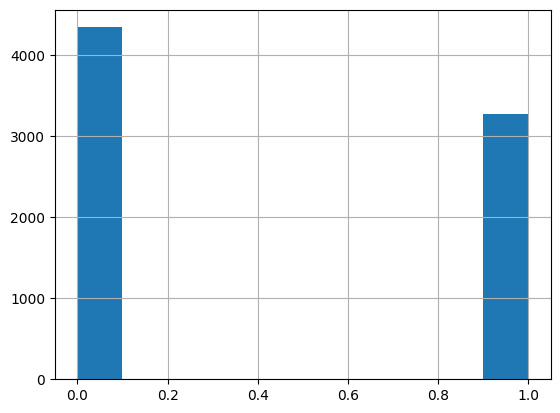


Targets ratio (0:1): 4342:3271


In [9]:
targets = df["target"].values
zero_targets = [target for target in targets if target == 0]
ones_targets = [target for target in targets if target == 1]
pd.Series(targets).hist()
plt.show()
print(f"\nTargets ratio (0:1): {len(zero_targets)}:{len(ones_targets)}")

As you can see from the above histogram, there is about a 1000 sample difference between the targets. The number of zeros are way higher than the number of ones, this can impact the performance of the model negatively. To combat this we can stratify the y variable making the zeros and ones have the approximately same number of samples in the X_train_fbe and X_test_fbe

## Dataset split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X, y = df["text"].values, df["target"].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [13]:
print(f"Shape of X_train: {X_train.shape}, shape of X_test: {X_test.shape}")

Shape of X_train: (5709,), shape of X_test: (1904,)


## Tokenization
We will tokenize our data using frequency based encoding. It works by getting a corpus based on popoularity, selecting x most popular words, convert those to integers, recreating dataset only with those numerical mappings of the words

In [14]:
import nltk
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [15]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stopwords_arr = set(stopwords.words("english"))

In [17]:
def tokenize(array, no_words=5000):
  # Removing stopwords
  word_list = []
  for text in array:
    for word in text.lower().split():
      p_word = helper.preprocess_word(word)
      if p_word not in stopwords_arr:
        word_list.append(p_word)
  
  corpus = Counter(word_list) # Dictionary returning all words as keys and their frequency usage as values
  corpus = sorted(corpus, key=corpus.get, reverse=True)[:no_words] # Selecting x most common
  word_to_idx = {x: i for i, x in enumerate(corpus)}

  idx_array = []
  for text_un in array:
    text = text_un.lower().split()
    idx_array.append([word_to_idx[helper.preprocess_word(word)] for word in text
                      if helper.preprocess_word(word) in word_to_idx.keys()])

  return np.array(idx_array)

In [18]:
X_train_fbe = tokenize(X_train)
X_test_fbe = tokenize(X_test)
assert X_train_fbe.dtype == object

Let's plot some data for EDA

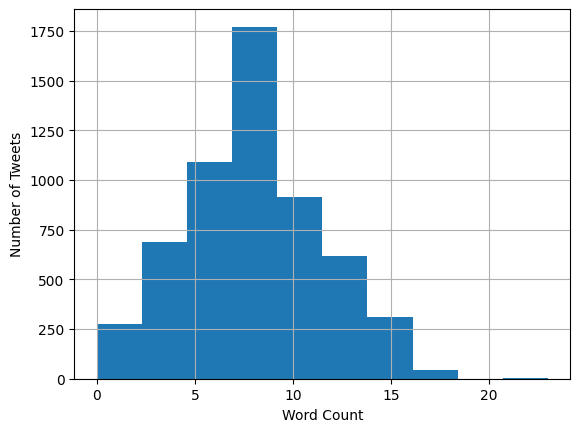

count    5709.000000
mean        8.007882
std         3.485947
min         0.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        23.000000
dtype: float64

In [19]:
data_length = [len(i) for i in X_train_fbe]
data_length = pd.Series(data_length)
data_length.hist()
plt.xlabel("Word Count")
plt.ylabel("Number of Tweets")
plt.show()
data_length.describe()

We can see that 75% of the samples have 12 words meaning we can pad them to 15 for better performance

## Padding


In [20]:
len(X_train_fbe), X_train_fbe.shape

(5709, (5709,))

In [21]:
def pad_(array, seq_len, dtype=int, pad_value=0):
  max_len = max(len(seq) for seq in array)
  if seq_len < max_len: print("WARNING: New sequence length is less then the length of some samples.")

  pad_len = seq_len - max_len
  padded_arr = np.zeros((len(array), max_len + pad_len), dtype=dtype)

  for i, seq in enumerate(array):
    seq_ = seq[:seq_len]
    padded_arr[i, :len(seq_)] = seq_
  
  return padded_arr

In [22]:
X_train_fbe = pad_(X_train_fbe, 15)
X_test_fbe = pad_(X_test_fbe, 15)

# Model Selection
We will try out a bunch of ml algorithms and simply choose the one with the highest accuracy.

Here the models we shall test:

* Naive Bayes
* Gaussian Naive Bayes
* SVMs
* Random Forest

In [23]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.exceptions import NotFittedError

In [59]:
def train_and_predict(model, model_name, X_train_fbe, y_train, X_test_fbe, y_test):
  model.fit(X_train_fbe, y_train)
  y_pred = model.predict(X_test_fbe)

  accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
  precision = round(precision_score(y_test, y_pred) * 100, 2)
  recall = round(recall_score(y_test, y_pred) * 100, 2)
  f1 = round(f1_score(y_test, y_pred) * 100, 2)

  print("="*100)
  print(f"{model_name} Evaluation: accuracy: {accuracy}, precision: {precision}, recall score: {recall}, f1 score: {f1}")

  return {accuracy, precision, recall, f1}

In [60]:
mnb = MultinomialNB()
gnb = GaussianNB()
svc = SVC(C=0.5)
rfc = RandomForestClassifier(criterion="entropy")
knn = KNeighborsClassifier(n_neighbors=100, weights="distance")

In [61]:
mnb_eval = train_and_predict(mnb, "MultinomialNB", X_train_fbe, y_train, X_test_fbe, y_test)
gnb_eval = train_and_predict(gnb, "GaussianNB", X_train_fbe, y_train, X_test_fbe, y_test)
svc_eval = train_and_predict(svc, "Support Vector Classifier", X_train_fbe, y_train, X_test_fbe, y_test)
rfc_eval = train_and_predict(rfc, "Random Forest Classifier", X_train_fbe, y_train, X_test_fbe, y_test)
knn_eval = train_and_predict(knn, "K-Nearest Neighbors", X_train_fbe, y_train, X_test_fbe, y_test)

MultinomialNB Evaluation: accuracy: 57.83, precision: 50.88, recall score: 52.81, f1 score: 51.83
GaussianNB Evaluation: accuracy: 56.51, precision: 48.82, recall score: 25.31, f1 score: 33.33
Support Vector Classifier Evaluation: accuracy: 60.71, precision: 58.25, recall score: 30.2, f1 score: 39.77
Random Forest Classifier Evaluation: accuracy: 59.4, precision: 53.61, recall score: 40.83, f1 score: 46.36
K-Nearest Neighbors Evaluation: accuracy: 59.82, precision: 54.71, recall score: 37.65, f1 score: 44.61


From this we can see that we are not able to achieve good results with different algorithms or hyperparameters tuning, this indicates that maybe the data pre-processing is done wrong. So let's try changing that.

# Changing the way we tokenize data
As mentioned before since a lot of models even with tuning did not recieve good performance, it indicated we needed change in the preprocessing method. So we will use sbert's tokenization instead.

It works by tokenizing words how bert does it. Then applying pooling layers to capture the semantic meaning of sentences in a single vector.

Bert tokenizes the data by breaking sentences into words, breaking words into sub words, assigns numbers to those subwords using bert's vocabulary, adds special tokens (i.e CLS (beginning token), SEP (Spaces token), PAD (Padding token)), and then assigns ids to each data sample

In [27]:
!pip install -q -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00


In [28]:
from sentence_transformers import SentenceTransformer

In [29]:
enc_model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

In [30]:
X_train_sbert = enc_model.encode(X_train)
X_test_sbert = enc_model.encode(X_test)

Now let's try the different algorithms once again but this time on the sbert preprocessed data. Also we cannot use Naive Bayes or Gaussain Naive Bayes because the sbert preprocessing method has used negative values.

In [66]:
svc = SVC(C=0.3)
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()

In [67]:
svc_eval = train_and_predict(svc, "Support Vector Classifier", X_train_sbert, y_train, X_test_sbert, y_test)
rfc_eval = train_and_predict(rfc, "Random Forest Classifier", X_train_sbert, y_train, X_test_sbert, y_test)
knn_eval = train_and_predict(knn, "K-Nearest Neighbors", X_train_sbert, y_train, X_test_sbert, y_test)

Support Vector Classifier Evaluation: accuracy: 82.46, precision: 84.08, recall score: 72.98, f1 score: 78.14
Random Forest Classifier Evaluation: accuracy: 81.04, precision: 83.85, recall score: 69.19, f1 score: 75.82
K-Nearest Neighbors Evaluation: accuracy: 79.25, precision: 76.14, recall score: 75.31, f1 score: 75.72


Because SVC model performed the best we will use it for our final competition predictions

# Testing with our own text

In [82]:
def predict_text(text, label=None, display_results=True):
  text_enc = enc_model.encode(text)
  prediction = svc.predict(text_enc.reshape((1, -1)))
  pred_label = "disaster" if prediction > 0.5 else "non-disaster"
  if display_results: print(f"True label: {label}, Predicted label: {pred_label}")
  return prediction, pred_label

In [83]:
_, _ = predict_text("Huge flooding in Pakistan. Millions of lives lost.", label="disaster")

True label: disaster, Predicted label: disaster


In [84]:
_, _ = predict_text("I won a lottery ticket today! Now that was not a disaster!", label="non-disaster")

True label: non-disaster, Predicted label: non-disaster


# Creating submissions file

In [91]:
from google.colab.files import download

In [85]:
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
test_df.drop(["keyword", "location", "id"], axis=1, inplace=True)
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [86]:
inputs = enc_model.encode(test_df["text"].values)

In [87]:
predictions = svc.predict(inputs)
predictions[:5]

array([1, 1, 1, 1, 1])

In [103]:
final_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))
final_df["target"] = predictions
final_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [104]:
final_df.to_csv("submission.csv", index=False)

# Submitting to competition

In [94]:
print("Installing kaggle")
!pip install kaggle -q
print("Upload kaggle.json")
upload()
print("Setting kaggle up...")
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -fr sample_data
print("Done!")

Installing kaggle
Upload kaggle.json


Saving kaggle.json to kaggle.json
Setting kaggle up...
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Done!


In [105]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Disaster predictions using SVC"

100% 22.2k/22.2k [00:01<00:00, 21.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets